In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.stats.weightstats import ztest
import statsmodels
import scipy

In [89]:
path = '../data/processed_data/df1_one_hot.gz'# path to final file 
path_feature = '../data/processed_data/RF_important_feature.csv' #path to important featuers
df1 = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"')
df1_path_feature = pd.read_csv(path_feature)

In [121]:
df1_path = '../data/processed_data/accept_downsampled_by_hardship.csv'
df1 = pd.read_csv(df1_path)

In [122]:
del df1['Unnamed: 0']

In [123]:
#separate dataset
df1_h = df1.loc[df1['hardship'] == 1]
df1_nh = df1.loc[df1['hardship'] == 0]

In [93]:
#load important feature
#input df; output: list of features
def df_to_lis(df):
    return list(df['0'][:30])

### Bonferroni Correction

In [94]:
feature_lis = df_to_lis(df1_path_feature)
p = 0.05 #original p
new_p = 0.05/len(feature_lis)

In [95]:
new_p

0.0016666666666666668

In [96]:
feature_res_dict = dict() #dict {feature(str): reject(bool)}

import statsmodels.stats.weightstats as ws

for feature in feature_lis:
    
    feature_h = df1_h[feature].copy()
    feature_nh = df1_nh[feature].copy()
    
    
    #transform to approximately normal
    feature_h = scipy.stats.yeojohnson(feature_h)[0]
    feature_nh = scipy.stats.yeojohnson(feature_nh)[0]
    
    col1 = ws.DescrStatsW(feature_h)
    col2 = ws.DescrStatsW(feature_nh)
    
    cm_obj = ws.CompareMeans(col2, col1)
    
    zstat, z_pval = cm_obj.ztest_ind(usevar='unequal')
    
    #conduct p val
    #zstats, p_val = statsmodels.stats.weightstats.CompareMeans.ztest_ind(feature_h, feature_nh, usevar='unequal', value=0)
    
    #print(p_val)
    #check if a feature is significant
    feature_res_dict[feature] = (z_pval, zstat, z_pval < new_p)
    
    #print(z_pval)

In [88]:
import numpy as np
from scipy.stats import chi2_contingency

def chisquare(variable, df_nh, df_h):
    
    hardship = []
    n_hardship = []
    
    if variable == 'veri':
        
        for tag in ['veri_0', 'veri_1', 'veri_2']:
            hardship.append(df_h[tag].sum())
            n_hardship.append(df_nh[tag].sum())
    
    else:
        assert(variable == 'home')
        
        for tag in ['home_own_0', 'home_own_1', 'home_own_2', 'home_own_3']:
            hardship.append(df_h[tag].sum())
            n_hardship.append(df_nh[tag].sum())
    
    data = np.array([hardship, n_hardship])
    
    chi2, p, dof, ex = chi2_contingency(data, correction=False)
    
    return p

chisquare('home', df1_nh, df1_h)

3.13434406231674e-14

In [101]:
chisquare('home', df1_nh, df1_h) < new_p

True

In [100]:
chisquare('veri', df1_nh, df1_h) < new_p

True

### SVM Testing

In [102]:
svm_path = '/Users/mac/Desktop/untitled folder/svm_importance.csv'

In [103]:
svm_df = pd.read_csv(svm_path)

In [108]:
feature_lis = svm_df['1'][:30]

In [110]:
feature_res_dict = dict() #dict {feature(str): reject(bool)}

import statsmodels.stats.weightstats as ws

for feature in feature_lis:
    
    feature_h = df1_h[feature].copy()
    feature_nh = df1_nh[feature].copy()
    
    
    #transform to approximately normal
    feature_h = scipy.stats.yeojohnson(feature_h)[0]
    feature_nh = scipy.stats.yeojohnson(feature_nh)[0]
    
    col1 = ws.DescrStatsW(feature_h)
    col2 = ws.DescrStatsW(feature_nh)
    
    cm_obj = ws.CompareMeans(col2, col1)
    
    zstat, z_pval = cm_obj.ztest_ind(usevar='unequal')
    
    #conduct p val
    #zstats, p_val = statsmodels.stats.weightstats.CompareMeans.ztest_ind(feature_h, feature_nh, usevar='unequal', value=0)
    
    #print(p_val)
    #check if a feature is significant
    feature_res_dict[feature] = (z_pval, zstat, z_pval < new_p)
    
    #print(z_pval)

### Tree

In [246]:
feature = ['dti', 'total_rev_hi_lim', 'unemployment_insur', 'annual_inc', 'open_acc']

In [247]:
y = df1['hardship']
col_lis = list(df1.columns)
col_lis.remove('hardship')
X = df1[feature]

In [248]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=150000)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.7, random_state=150000)

In [249]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy', max_leaf_nodes = 25)
clf = clf.fit(X_train, y_train)

In [250]:
import graphviz 

In [251]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)

'/Users/mac/Desktop/untitled folder/tree.pdf'

In [252]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['hardship', 'non-hardship'],  
                      filled=True, rounded=True,  
                      special_characters=True)

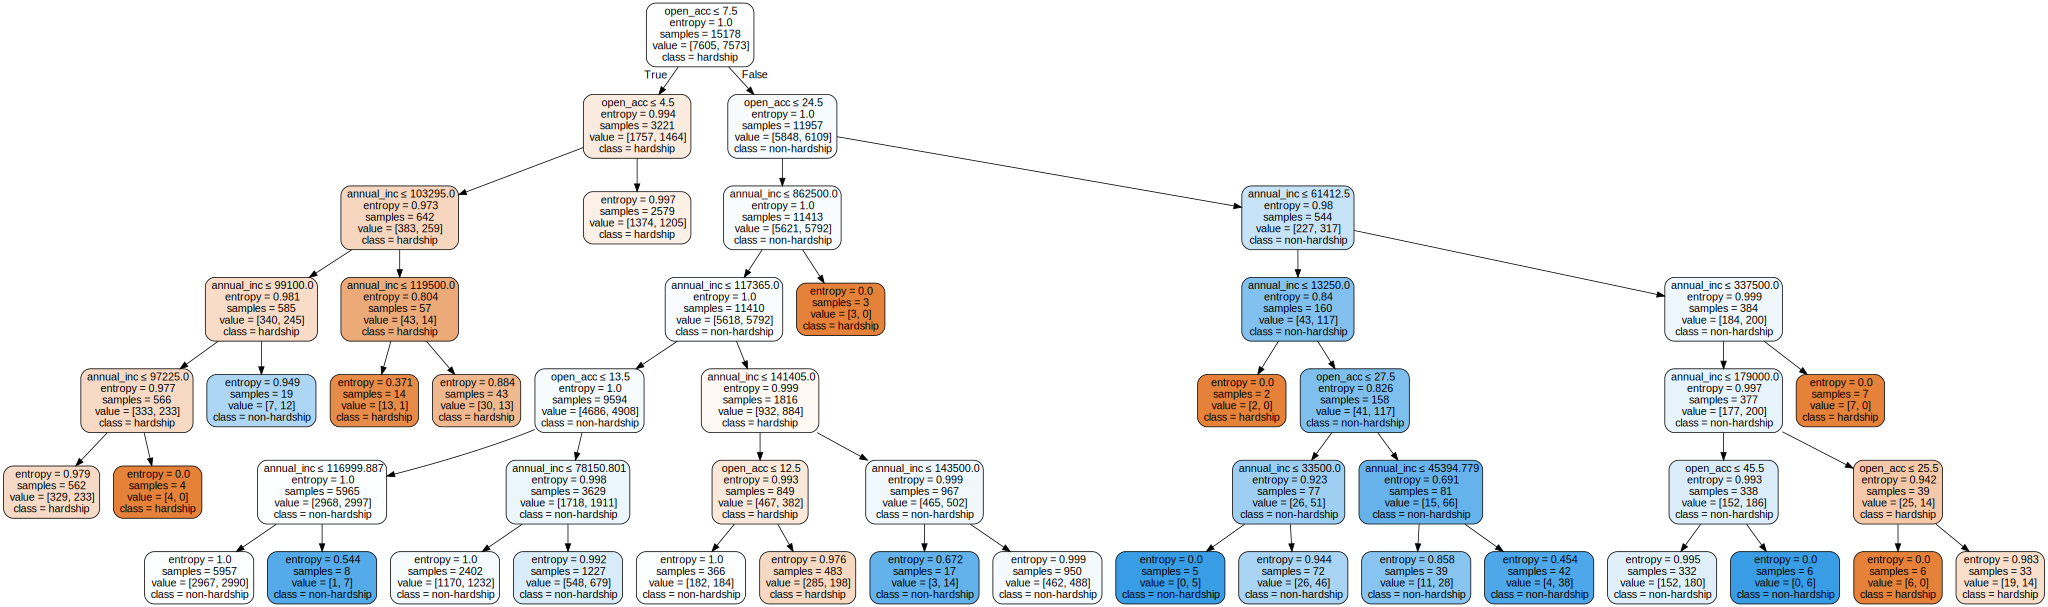

In [253]:
graph = graphviz.Source(dot_data)

# graph.render("/Users/mac/Desktop/untitled folder/tree")  #path to save file